# Lab04 Exercises
UW Geospatial Data Analysis  
CEE467/CEWA567  
David Shean

# Goals
* Review some fundamental concepts that are common to most geospatial analysis
* Learn basic operations with Geopandas
* Explore coordinate systems, projections and transformations, geometry types
* Understand how different projections can distort measurements and visualizations
* Create more sophisticated visualizations involving multiple layers and data types

## Part 1: Exploring CRS and Projections

### Import necessary modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import fiona
import pyproj

In [ ]:
#%matplotlib widget
%matplotlib inline

### Load sample vector data: world polygons
* See example (and lots of relevant info): https://geopandas.org/projections.html
* This GeoDataFrame containing attributes and Polygon geometries for all countries is conveniently bundled with Geopandas

### Inspect the world GeoDataFrame
* Review the columns
* Note geometry types: both Polygon and MultiPolygon - why the difference? 🤔

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


### Check the coordinate reference system (crs)

### Look up this EPSG code online
* See top of `crs` output
* Burn this code in your brain
* What are units? ✍️

### Plot the GeoDataFrame using the convenient `plot` method with default settings
* Note that this is a 2D representation of geographic coordinates (lon,lat), known as Equirectangular, Equidistant Cylindrical, and "Plate Carrée" (flat square in French) projection
* https://en.wikipedia.org/wiki/Equirectangular_projection

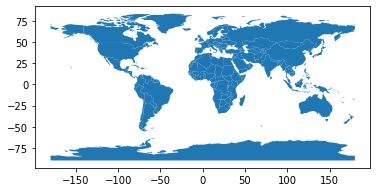

## Change the world!
* Reproject the world GeoDataFrame to another common, global projection: Web Mercator
    * This is one of the most common projections used for online maps (e.g., Google Maps) and tiled basemaps
    * https://en.wikipedia.org/wiki/Web_Mercator_projection
* Look up (or recall from memory) the appropriate EPSG code
* Use the GeoPandas `to_crs()` function to reproject the world GeoDataFrame to Web Mercator and create a new plot
    * If you didn't review it earlier, now might be a good time to take a look at this documentation: https://geopandas.org/en/stable/docs/user_guide/projections.html#re-projecting

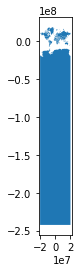

### Workaround for Antarctica (more discussion later)

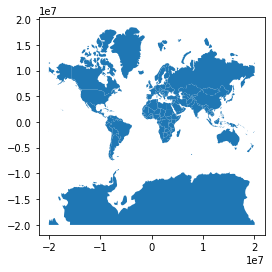

In [ ]:
#https://tipsfordev.com/how-to-remove-shapes-that-cause-a-problem-upon-reprojection-from-a-geopandas-dataframe
from shapely.geometry import box
crs = pyproj.CRS.from_epsg(3857)
bounds = crs.area_of_use.bounds
gpd.clip(world, box(*bounds)).to_crs('EPSG:3857').plot();

### Take a moment to consider the two plots 🤔
* Note the range of axes tick labels and units
* Note map distortion

## Define a custom projection
* Set the origin of your projection on the (self-proclaimed) "Center of the Universe" – Fremont, Seattle, WA, Earth
    * https://www.atlasobscura.com/places/center-of-the-universe-sign
    * You'll probably need to look up some coordinates
* Let's start by creating a proj string (make sure you use sufficient precision for decimal degrees)
    * https://proj.org/usage/quickstart.html
    * Choose a simple projection that accepts a center latitude and center longitude (e.g., orthographic)
        * See reference: https://proj.org/operations/projections/ortho.html
    * Your string should look something like `'+proj=ortho +lon_0=YY.YYYYYYY +lat_0=XXX.XXXXXXX'`
    * Make sure the order and sign of your latitude and longitude values make sense (sanity check!)

### Reproject and plot
* Use GeoPandas `to_crs()` method to reproject the world GeoDataFrame using your local projection, reducing our beautiful [multidimensional universe](http://mentalfloss.com/article/501926/how-many-dimensions-are-there) to a 2D plot
* The `plot()` method returns a matplotlib axes object - store this as new variable called `ax`
* Modify this axes object to add thin, black horizontal lines where y=0 and a vertical line where x=0, producing "crosshairs" on the origin
    * See the matplotlib `axvline()` and `axhline()` methods
    * The "line width" keyword `lw` may be useful

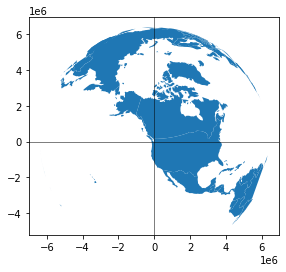

### Again, again!
* Let's experiment with a few additional projections, creating plots like the one above with crosshairs for the origin
* This time, use some EPSG codes
    * Note that some documentation on the web for Python geospatial packages still uses the outdated `init` syntax when specifying EPSG - this is not necessary, can just pass a string like `'EPSG:XXXX'` to the `to_crs()` method
        * For more details: https://pyproj4.github.io/pyproj/dev/gotchas.html#init-auth-auth-code-should-be-replaced-with-auth-auth-code
* Try the following:
    * EPSG:3031 - South Polar Stereographic (see if you can find Antarctica, might need to zoom in)
    * The EPSG code for the UTM zone on WGS84 ellipsoid that contains Seattle
        * see https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system
        * Note: If you search for "UTM 10N" in the EPSG registry, you may get several returns: https://epsg.io/?q=UTM+10N. These are all valid, but they use different ellipsoids/datums. You want the code for the WGS84 ellipsoid definition.
    * US National Atlas Equal area (EPSG:2163)
    * One or more additional EPSG codes of your choosing
* Since we have to do this several times, maybe it would be good to define a function that accepts a geodataframe and an EPSG code as arguments, then does the reprojection and plotting (no need to return anything at this point). Then we could use a simple for loop to call the function for each EPSG code!  Nice and clean, and better than copying/pasting.
* Note: you may see some strange issues with "lines" across the map, or an apparently empty map (try zooming in on 0,0). You didn't do anything wrong, see next section...

### OK, something isn't right with some of these maps
* Note some polygons (countries) cross the antimeridian (-180°/+180° lon) or one of the poles (+90° or -90° lat, like, say Antarctica). Or polygons could extend beyond the valid extent for the target projection. These polygons won't render correctly.
    * If using a regional projection for local or regional analysis (e.g., UTM or state plane coordinate system), you probably don't care about polygons from the other side of the planet anyway. 
    * The solution is to isolate or clip polygons of interest before reprojecting.

## Isolate North American polygons
* Start with a quick inspection of the `world` GeoDataFrame
* You should be able to use the standard Pandas "selection by label" approach (`.loc`) to isolate records for countries in North America
    * This can be done using a conditional statement, which will return a boolean array for selection
    * Store the output in a new GeoDataFrame
* Regenerate the same plots (with your handy function!) using this new GeoDataFrame

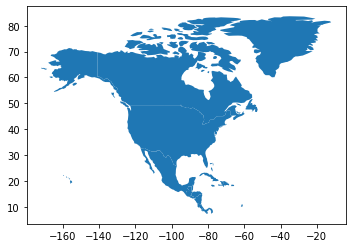

### That looks better!
* Note the location of the origin, apparent size and distortion of polygons (e.g., Mexico, Alaska and Greenland) on each plot 🤔

## Part 2: ICESat may be dead, but the points live on...
* Let's continue to play with the CONUS GLAS dataset to explore projections using GeoPandas

### Load the existing csv into a Pandas DataFrame
* Define the relative path to the csv as in previous labs
* Use the amazing Pandas `read_csv()` function to load as a Pandas DataFrame
* Run a quick `head()` on your DataFrame to make sure everything looks right

In [ ]:
#Make sure you update with your relative path to the csv!
glas_fn = '../01_Shell_Github/data/GLAH14_tllz_conus_lulcfilt_demfilt.csv'
glas_df = pd.read_csv(glas_fn)
glas_df.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31


### Convert the Pandas `DataFrame` to a GeoPandas `GeoDataFrame`
* See documentation here: https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html
* Careful about lon and lat order!
* Store in a variable named `glas_gdf` (needed for sample code later)
* Run a quick `head()` to make sure everything looks good
* You should have a new `geometry` column cointaining shapely Point objects

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,geometry
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31,POINT (-105.35656 44.15790)
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31,POINT (-105.35812 44.15017)
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31,POINT (-105.35843 44.14863)
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31,POINT (-105.35874 44.14709)
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31,POINT (-105.35905 44.14554)


### A note on `Point` geometry objects
* The coordiantes in the special `geometry` column of a `GeoDataFrame` are actually `Point` objects from the Shapely library
    * https://shapely.readthedocs.io/en/latest/manual.html
    * https://shapely.readthedocs.io/en/latest/manual.html#points
* We will revisit geometry objects, and explore `Polygon` objects in more detail during the Vector2 lab

### Set the GeoDataFrame CRS
* https://geopandas.org/en/latest/docs/user_guide/projections.html#setting-a-projection
* Note that you can also define this during the initial GeoDataFrame creation, passing the appropriate EPSG code as an argument for the `crs` keyword (`gpd.GeoDataFrame(pandas_df, crs='EPSG:XXXX', geometry=...)`

### Run a quick check to make sure CRS is set correctly!
* Inspect the `crs` for your GeoDataFrame

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Get bounding box (extent) and center (lon, lat) of GLAS points
* See GeoPandas API reference. In this case, you want the `total_bounds` attribute: https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.total_bounds.html
    * Try to avoid copying/pasting and hardcoding values - store the output from `total_bounds` as a new variable, then use the array indices to get the corresponding min/max values
    * Note that `bounds` will return the bounds of each record in the GeoDataFrame (in this case, just the point coordinates), while `total_bounds` returns the union for all records
* Center can be calculated from the min/max extent values in each dimension

In [ ]:
#Alternative approach using convex hull
#print(glas_gdf.unary_union.convex_hull.centroid)

### Plot the points using the convenience `plot` method of the GeoDataFrame
* Note that unlike the Pandas scatterplot function, you no longer need to specify the DataFrame columns containing the x and y values - GeoPandas will assume you want to use x and y values in Geometry objects
* Color points by 'glas_z' values
    * Note: GeoPandas syntax for this is slightly different than Pandas
* Set point size appropriately
* Add a colorbar
    * https://geopandas.org/en/latest/docs/user_guide/mapping.html#creating-a-legend
    * Note: if desired, you can pass a dictionary of colorbar properties (e.g., `{'label':'Elevation (m)'}`) to `legend_kwds`
        * Even better, specify the vertical datum of the elevation values, in this case height above the WGS84 ellipsoid
* Don't specify a `figsize` for this plot (though fine to do this elsewhere), just use the default figure size.

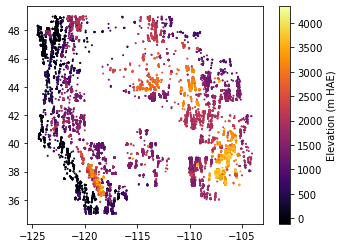

## Geographic coordinate sanity check
OK, great, GeoPandas makes creating this plot a little easier than last week. 

Now, let's dig a little deeper and think about this map.

Note that the default aspect ratio for the above map is 'equal', so the x and y scaling is the same
* Check this by quickly using a ruler or piece of paper to measure the distance spanned by 10° on each axis on your screen (in mm) 

### Questions
Discuss the following with your neighbor/group and provide answers in the notebook:

1. Are there any potential issues with this scaling for our geographic coordinates (latitude and longitude in decimal degrees)? ✍️

Do the following quick calculations for a spherical Earth (or attempt some more sophisticated geodetic distance calculations, if desired).  Drawing a quick sketch is likely useful as you think through this (no need to reproduce your sketch here).

2. ✍️ What is the length (in km) of a degree of **latitude**  at:
    * 0° latitude (equator)
    * 90° latitude (pole)
    * 35° latitude?  49° latitude? (these are the approximate min and max latitude values of the GLAS point data)
3. ✍️What is the length (in km) of a degree of **longitude** at:
    * 0° latitude (equator)
    * 90° latitude (pole)
    * 35° latitude?  49° latitude?
4. Based on these values, does your map above have an equal aspect ratio in terms of true distance (in km)? ✍️

### Extra credit
Create a plot showing the relationship between the length of a degree of longitude in km as a function of latitude in decimal degrees for a range of 0 to 90 degrees latitude.  Add two red points for 35 and 49.  Fine to assume a spherical earth with average radius.

Hmmm. So how do we deal with these scaling issues?

## Part 3: Use a projected coordinate system!

We need to choose a map projection that is appropriate for our data and objectives. This decision is important for visualization, but is also critical for precise quantitative analysis. For example, if you want to analyze area or volume change, you should use an equal-area projection. If you want to analyze distances between points, you should use an equidistant projection.

https://www.axismaps.com/guide/general/map-projections/

Sadly, there is no "perfect" projection. https://en.wikipedia.org/wiki/Map_projection#Which_projection_is_best? 

You, as the mapmaker or data analyst, are responsible for choosing a projection with the right characteristics for your purposes. Let's explore a bit further, and we'll revisit some general guidelines later.

### Use GeoPandas to reproject your GeoDataFrame
* Start by reprojecting the points to a Universal Transverse Mercator (UTM), Zone 11N on the WGS84 Ellipsoid
    * You'll have to look up the appropriate EPSG code
* Store the output as a new GeoDataFrame with a unique name (e.g., `glas_gdf_utm`)
* Do a quick `head()` and note the new values in the `geometry` column

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,geometry
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31,POINT (1431183.070 4955789.787)
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31,POINT (1431181.915 4954913.882)
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31,POINT (1431181.639 4954738.855)
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31,POINT (1431181.394 4954563.604)
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31,POINT (1431181.226 4954388.366)


### Create a new plot of the reprojected points
* Note the new coordinate system origin (0,0), units, and aspect ratio

### OK, what did we just do?

Under the hood, GeoPandas used the `pyproj` library (a Python API for PROJ) to transform each point from one coordinate system to another coordinate system.  

I guarantee that you've all done this kind of thing before, you may just not remember it or recognize it in this context. See: https://en.wikipedia.org/wiki/List_of_common_coordinate_transformations

Transforming coordinates on the surface of the same reference ellipsoid is pretty straightforward. Things start to get more complicated when you include different ellipsoid models, horizontal/vertical datums, etc. Oh, also the Earth's surface is not static - plate tectonics make everything more complicated, as time becomes important, some coordinate systems remain "fixed" relative to a moving plate (e.g., NAD83), and transformations must include a "kinematic" component.  

Fortunately, the `PROJ` library (https://proj.org/about.html) has generalized much of the complicated math for geodetic coordinate transformations. It's been under development since the 1980s, and our understanding of the Earth's shape and plate motions has changed dramatically in that time period (thanks to GNSS like GPS and other satellite observations). So, still pretty complicated, and there are different levels of support/sophistication in the tools/libraries that use `PROJ` (like GeoPandas).

We aren't going to get into the details here, but feel free to take a look at the Transformations section here to get a sense of how this is actually accomplished: https://proj.org/operations/index.html

## Define a custom projection for Western U.S.

The UTM projection we used above is not the best choice for our data, which actually span 4 UTM zones:
https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system#/media/File:Utm-zones-USA.svg. Each UTM zone is a north-south "slice" of the Earth's surface covering 6° of longitude around a central meridian.

We used UTM Zone 11N, and while distortion should be limited around the -117°W central meridian, it will increase with distance beyond the -120° to -114°W zone boundaries.

Let's instead use a custom Albers Equal Area (AEA) projection to minimize area distoration over the full spatial extent of our GLAS points.

To do this, we'll define a PROJ string (https://proj.org/usage/quickstart.html?highlight=definition), which can be interpreted by most Python geopackages (like `pyproj`).

This interactive tool might be useful to explore some options for a user-defined bounding box: https://projectionwizard.org/

The Albers Equal Area projection definition requires two standard parallels: https://proj.org/operations/projections/aea.html.  Here, we will also specify the center latitude and center longitude for the coordinate system origin.

* Define a custom Albers Equal Area proj string `'+proj=aea...'`
    * https://en.wikipedia.org/wiki/Albers_projection
    * PROJ reference, with example: https://proj.org/operations/projections/aea.html
* Use the center longitude and latitude of the GLAS points you calculated earlier
* Define the two standard parallels (lines of latitude) based on the latitude range of the points
    * Map scale will be true along these parallels, with distortion increases as you move north or south
    * One simple approach would be to use min and max latitude from the `total_bounds` extent computed earlier
        * This is fine, but note that this could lead to additional distortion near your center latitude
        * Extra Credit: figure out how to place them slightly inside your min and max latitude to minimize distortion across the entire latitude range
            * This might be useful: https://www.sciencedirect.com/science/article/pii/S009830041630053X (one of the "Existing Recommendations" is fine)
* Use Python string formatting to dynamically create your proj string (don't just hardcode your values, but substitute variables in the string)
* Print the final proj string

### Reproject the GLAS points using your custom equal-area projection
* Store the output as a new GeoDataFrame and check that the `geometry` was updated.
* Sanity check with a scatter plot
    * Origin should be near center of GLAS points

### Extra Credit: Create scatter plots for comparison
* 4 subplots (WGS84, UTM, custom AEA, and Web Mercator)
* Might be useful to add gridlines with constant spacing (somewhere between ~200-500 km might work) to each plot for projected data using matplotlib `grid()`

In [ ]:
from matplotlib.ticker import MultipleLocator

def add_grid(ax, tick_interval=500000):
    ax.xaxis.set_major_locator(MultipleLocator(tick_interval))
    ax.yaxis.set_major_locator(MultipleLocator(tick_interval))
    ax.grid()

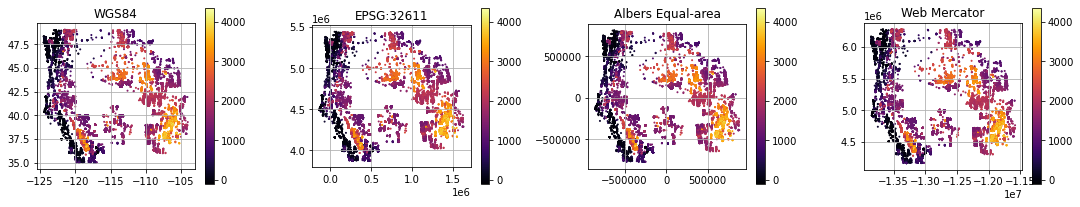

### Umm, they kind of look the same.  Why am I wasting time on this?

* Note the location of the origin for each coordinate system 🤔
    * The (0,0) should be near the center of your points for the AEA projection
* Note subtle distortion of points near the margins
* Let's dive into some analysis of distances, azimuths and areas to evaluate projection distortion

## Part 4: Distance and azimuth distortion analysis
* We will now explore how these projections affect distances and angles
* Let's start by defining two points from our dataset separated by a large distance - we can use points corresponding to minimum and maximum longitude values

In [ ]:
min_idx = glas_gdf['lon'].argmin()
max_idx = glas_gdf['lon'].argmax()
glas_gdf_mmlon = glas_gdf.iloc[[min_idx, max_idx]]
glas_gdf_mmlon

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,geometry
51195,2007.755506,732952.759794,47.674555,-124.482406,-22.16,-23.08,0.81,31,POINT (-124.48241 47.67455)
57909,2008.191175,733111.970228,39.281164,-104.052336,1729.57,1730.57,0.97,31,POINT (-104.05234 39.28116)


### Create a quick plot to visualize

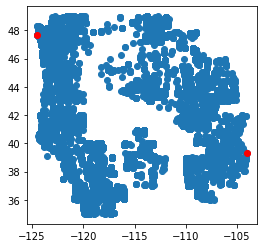

In [ ]:
f, ax = plt.subplots()
glas_gdf.plot(ax=ax)
glas_gdf_mmlon.plot(ax=ax, color='r');

### Compute Geodetic distance and azimuth between these points
* This is our "truth" - the geodetic distance along the 3D surface of the ellipsoid
* Turns out calculating this is not as straightforward as it may sound: 
    * https://en.wikipedia.org/wiki/Geographical_distance
    * https://en.wikipedia.org/wiki/Geodesics_on_an_ellipsoid
    * This is one of the main reasons that we use 2D planar projections! Geometric calculations become much simpler in 2D compared to the curved 3D surface of an ellipsoid.
* Fortunately, there are approximations and several mature tools/libraries with code to do this efficiently
* We will use the pyproj functionality here
    * https://pyproj4.github.io/pyproj/stable/api/geod.html

In [ ]:
from pyproj import Geod
#Define the ellipsoid to use for calculations
geod = Geod(ellps="WGS84")

#Compute geodetic distance between first and last point in a GeoDataFrame
#Return the distance and azimuth and back azimuth (degrees clockwise from north)
def geodetic_az_dist(gdf):
    #Extract the points
    p0 = gdf.iloc[0]
    p1 = gdf.iloc[-1]
    #Compute the geodesic azimuth, back azimuth and distance
    az, backaz, dist = geod.inv(p0['lon'], p0['lat'], p1['lon'], p1['lat'])
    #print('Distance: {:0.2f} km, Azimuth: {:0.2f}°, Back Azimuth: {:0.2f}°'.format(dist/1000., az, backaz))
    #return {'dist':dist, 'az':az, 'backaz':backaz}
    print('Distance: {:0.2f} km, Azimuth: {:0.2f}°'.format(dist/1000., az))
    return {'dist':dist, 'az':az}

In [ ]:
geo_da = geodetic_az_dist(glas_gdf_mmlon)

Distance: 1889.41 km, Azimuth: 112.06°


### Compute Euclidian distance and azimuth between these points for different projections
* You all know how to do this - Pythagorean theorem in a cartesian coordinate system
    * https://en.wikipedia.org/wiki/Euclidean_distance
* I've prepared some sample code here
* You will need to reproject the `glas_gdf_mmlon` dataframe and pass to the `euclidian_az_dist()` function defined below
* Please do this for: 
    * UTM Zone 11N
    * Web Mercator
    * Your AEA projection
    * Extra Credit: an azimuthal equidistant projection with projection center defined using the first point in the GeoDataFrame (you'll need to create a new proj string here, see https://proj.org/operations/projections/aeqd.html for reference)
* Note that the `euclidian_az_dist` function prints out values, but you may want to store the returned dictionary, and then use for later calculations

In [ ]:
def euclidian_az_dist(gdf):
    unit = gdf.crs.axis_info[0].unit_name
    if unit != 'metre':
        print('Input CRS has units of {}, expected projected CRS'.format(unit))
    else:
        dx = gdf.iloc[-1].geometry.x - gdf.iloc[0].geometry.x
        dy = gdf.iloc[-1].geometry.y - gdf.iloc[0].geometry.y
        az = np.degrees(np.arctan2(dx,dy))
        dist = gdf.distance(gdf.iloc[-1].geometry).iloc[0]
        #dist = np.sqrt(dx**2 + dy**2)
        print('Distance: {:0.2f} km, Azimuth: {:0.2f}°'.format(dist/1000., az))
        return {'dist':dist, 'az':az}

In [ ]:
#Note that GeoPandas is smart enough to raise exception when inputs are geographic (lat,lon)
euclidian_az_dist(glas_gdf_mmlon)

Input CRS has units of degree, expected projected CRS


### Analysis: which of these projections is closest to reality? ✍️
* Do some quick analysis of your findings
* I included a sample function that might be useful to compute percent difference from the "true" geodetic distance values

In [ ]:
def percdiff(d1, d2):
    key = 'dist'
    dist_diff = 100 * abs(d1[key] - d2[key])/d2[key]
    key = 'az'
    az_diff = 100 * abs(d1[key] - d2[key])/d2[key]
    print(f'Distance diff: {dist_diff:.2f}%, Azimuth diff: {az_diff:.2f}%')

In [ ]:
#Compare web mercator values to the geodesic values
print("Web Mercator:", wm_da)
print("Geodetic (truth):", geo_da)
percdiff(wm_da, geo_da)

Web Mercator: {'dist': 2615069.8042249978, 'az': 119.57892112999764}
Geodetic (truth): {'dist': 1889409.4231811771, 'az': 112.06063809048167}
Distance diff: 38.41%, Azimuth diff: 6.71%


## So what is going on here?
* You are seeing different types of distortion (distance, direction) for each projection, compared to the "true" geodetic values on the surface of the Ellipsoid.
* In this case, the distance distortion for some projections is <1%, but it's very possible that <1% will introduce unacceptable (and unnecessary) error for precise engineering applications. This distortion will increase as distances increase.
* It's important to pick a projection that is well-suited for your application.  If you care about accurate representation of distances, you should use an equidistant projection.  If you care about accurate representation of areas, use an equal-area projection.
* Remember, there's no "perfect" projection, so it's on you to account for this properly.  You would be surprised at how often errors due to projection decisions end up in published literature.
* Hopefully this was informative, and didn't just confuse the entire concept.  If you're lost or confused, ask for some help, and let's continue the discussion in class or on Slack!

## Part 5: Save the projected points to a GIS-ready file

### Export GeoDataFrame to CSV
* For convenience, let's add new columns for the x and y coordinates in the utm coordinates
* This should be pretty simple - no need for loops or a custom function here (hint: use the `x` and `y` attributes of the special `geometry` column).  Can store the projected x and y coordinates as new columns in your GeoDataFrame)
* Note: don't _need_ to do this, as the geometry column already stores this information, but sometimes you want to preserve projected coordinates (alongside lat/lon) if you're going to export as a csv and analyze with other tools (e.g., AutoCAD)
    * Warning: no information about projection is preserved in a standard CSV, just the coordinate values. It's on you to document projection in metadata before distributing
    * A better option is to use a GIS-ready file format (below) that embeds the CRS metadata along with the coordinates

In [ ]:
def gdf_add_xy(gdf):
    gdf['proj_x'] = gdf['geometry'].x
    gdf['proj_y'] = gdf['geometry'].y

In [ ]:
gdf_add_xy(glas_gdf_utm)

In [ ]:
glas_gdf_utm.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,geometry,proj_x,proj_y
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31,POINT (1431183.070 4955789.787),1.431183e+06,4.955790e+06
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31,POINT (1431181.915 4954913.882),1.431182e+06,4.954914e+06
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31,POINT (1431181.639 4954738.855),1.431182e+06,4.954739e+06
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31,POINT (1431181.394 4954563.604),1.431181e+06,4.954564e+06
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31,POINT (1431181.226 4954388.366),1.431181e+06,4.954388e+06


In [ ]:
out_fn='./conus_glas_utm.csv'
glas_gdf_utm.to_csv(out_fn)

#### Open the csv from Jupyter lab file browser to verify output looks good, with new columns

## Save GIS-ready files to disk
* Use fiona to get a list of available file type drivers for output
* Note: the 'r' means fiona/geopandas can read this file type, 'w' means it can write this file type, 'a' means it can append to an existing file.
    * https://fiona.readthedocs.io/en/latest/manual.html#writing-vector-data

In [ ]:
fiona.supported_drivers

## How to choose a file format?
* I'm guessing that most of you have used ESRI shapefiles in the past.
* Please stop 🛑.  This is a legacy format, though it is still widely used.
    * http://switchfromshapefile.org/
* Better options these days are Geopackage (GPKG) when spatial index is required, and simple GeoJSON for other cases
    * Both should be supported by any respectable GIS (including QGIS, ArcGIS, etc)
    * Note that GeoJSON is typically only used for geographic coordinates (EPSG:4326), not projected coordinates
    * https://feed.terramonitor.com/shapefile-vs-geopackage-vs-geojson/
* Now that you've made an informed decision for an output format, let's use the Geopandas `to_file()` method to create this file
    * Let's export to Geopackage for this exercise
    * Make sure you properly specify filename with extension and the `driver` option
    * *Note: Writing out may take a minute, and may produce an intermediate '.gpkg-journal' file*
        * Can see this in the file browser or terminal!

## 🎉

You can now directly load this gpkg file in any GIS, without defining a coordinate system or dealing with your original csv. You can also load this file directly into geopandas in the future using the `read_file()` method, without having to repeat the processing above. We'll do this for lab exercises in a few weeks. 

### See for yourself!

Try it! Right-click on file in the file browser on the left side of the JupyterLab interface, then select Download and pick a location on your local computer (e.g., your Downloads folder). 

Then open this file in QGIS or ArcGIS on your local machine!

## A quick aside: `gdalsrsinfo`

We covered basic shell and command line usage during in Week01. I included this because there are many powerful command-line utilities out there that can batch data processing and quick geospatial data inspection. The [GDAL/OGR command-line utilities](https://gdal.org/programs/index.html) are worth exploring - we will discuss more during raster module. Some of these have equivalent Python functions, while others do not.

One of these utilties, `gdalsrsinfo`, is great for quickly inspecting dataset CRS, converting between different CRS formats (WKT, proj strings, EPSG codes, etc), and exploring transformations between different CRS.

### Try it!
Open a new terminal, navigate to the directory where you just created the output file. Alternatively, you can run these shell commands from a notebook cell. Run the following (substituting your filename):
* `gdalsrsinfo EPSG:32611`
* `gdalsrsinfo yourfilename.gpkg`

By default, this will export a proj string and WKT for the crs. You can also output different formats (e.g., EPSG code). See `gdalsrsinfo -h` for usage. Try the `-o all` option.

## Part 6: Area Distortion

### Get polygons for US States

Hmmm, let's see.  Two choices:
1. We could go to ESRI or the U.S. Census website, identify and download a shapefile, unzip 4+ files, copy/paste the appropriate \*.shp filename into the notebook.  Wait, how can I download on a remote server?  OK, maybe run something like `wget http://...`, unzip, provide absolute path  
*- OR -*
2. Give geopandas a url string that points to a GeoJSON file somewhere on the web, and read dynamically

Yeah, let's go with #2

Let's use the US States 5M GeoJSON here: http://eric.clst.org/tech/usgeojson/

* We've talked about JSON as the text format used by Jupyter notebooks. GeoJSON extends this format to include geospatial information. It's pretty great. If you are unfamiliar, take a moment to read about GeoJSON: https://en.wikipedia.org/wiki/GeoJSON

### Quick inspection
Take a look at the [5M GeoJSON file](https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json) (digitized to preserve details at a scale of 1:5000000) contents in your browser or download and open with a text editor. 

Note organization structure. How does this compare to, say, a Python dictionary object? 🤔

### Read directly with GeoPandas
Read the file using GeoPandas by passing the url to `gpd.read_file()`.

In [ ]:
#states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
#states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_20m.json'

## Inspect the GeoDataFrame
* Note the columns and geometry type(s) in the `geometry` columns
* Do a quick `plot()` to preview

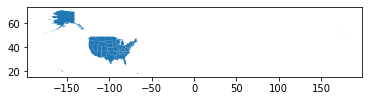

In [ ]:
states_gdf.plot();

*Note: The extent of the Aleutian islands (Alaska) crosses the -180/+180°W antimeridian, which is why the extent spans the full longitude range.*

### Check the CRS
* Note that this was automatically defined during the `read_file()` step.  Thanks GeoPandas!

## Compute the area (in $km^2$) for all states
* Our GeoDataFrame of states is still in geographic coordinates (decimal degrees)
    * We could compute area in decimal degrees, but remember our analysis above about how the length of a degree of longitude varies? This will also affect area calculations.
        * Hmm, also we want to avoid the costly 3D geodetic area calculations on the surface of the ellipsoid
    * We want polygon area values in km<sup>2</sup>
    * What might you need to do to the GeoDataFrame before you proceed?
        * Hint you've already done this a few times during the lab
        * ...

### Answer: reproject the polygons!
* Let's start by reprojecting the state polygons using the same UTM 11N projection we explored earlier
* Store output as a new GeoDataFrame with unique name (e.g., states_gdf_utm)
* Do a quick `head()` on the output to verify a change in geometry coordinates
* Do a quick `plot()`, noting the new coordinate values.

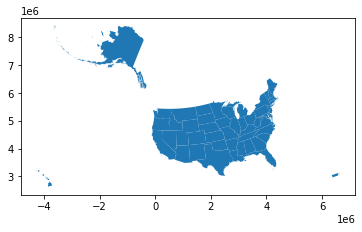

### Compute the area of the polygons in the projected GeoDataFrame
* Compute the area for each state in km^2
    * Don't use a loop - this should be straightforward to do using geopandas: https://geopandas.org/en/latest/docs/reference/api/geopandas.GeoSeries.area.html
* Compare your values with the values in the `CENSUSAREA` column
    * Calcuate an area difference between your values and the `CENSUSAREA` values
    * Note: `CENSUSAREA` values are in square miles (sigh), so you'll need to convert to square km
    * Convert the area difference to a percent difference
* Do your numbers agree?  If not, any guess about why not? (discuss with your neighbor)
    * Try sorting your GeoDataFrame by the percent difference column
    * What do you notice about the states with largest difference - how far are they from the UTM zone center longitude?

In [ ]:
#Sample function
def gdf_area_analysis(gdf):
    #Convert area from GeoPandas (m^2) to km^2
    gdf['myarea'] = gdf.area/1E6
    #Convert area from source data (mi^2) to km^2
    gdf['CENSUSAREA_km2'] = gdf['CENSUSAREA']*2.58999
    #Compute difference and store in new column
    gdf['area_diff'] = gdf['myarea'] - gdf['CENSUSAREA_km2']
    #Compute percent difference
    gdf['area_diff_perc'] = 100 * gdf['area_diff']/gdf['CENSUSAREA_km2']
    #Return a new dataframe with index sorted by percent difference
    return gdf.sort_values(by='area_diff_perc', ascending=False)

### Repeat for your Albers Equal Area projection

### Repeat for Web Mercator

### For each projection, create a choropleth plot showing the percent area difference for all states
* See https://geopandas.org/en/stable/docs/user_guide/mapping.html#choropleth-maps
* Specify common vmin and vmax values for intercomparison (e.g., 0 and 100%)

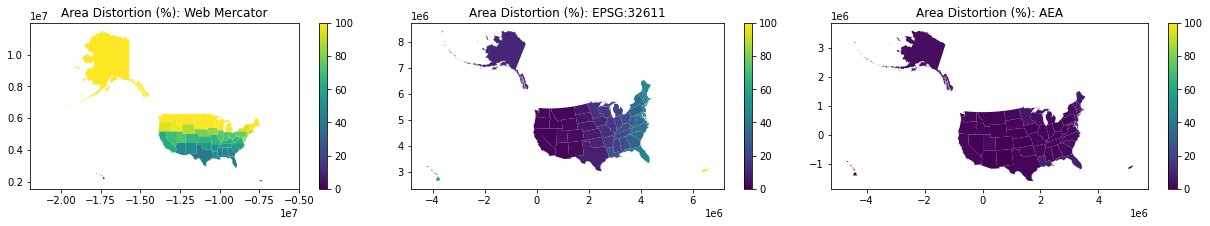

## Analysis
* Take a moment to consider how the area distortion differences vary for the different projections
* Are they spatially uniform?  How do they vary with distance from the projection center or latitude/longitude of true scale? 🤔
* Hopefully this helps to reinforce what touched on earlier with distances and the area - choice of projection is important depending on the intended analysis.  If you intend to do area analysis, you want to use an equal-area projection

*DES Note*

If you look closely, there are some residual area differences between `CENSUSAREA` and our equal-area polygons. This is likely related to coastlines, inland water bodies, mapping scale, and how the `CENSUSAREA` is computed.  Using the 20M or 500K polygons doesn't make much of a difference. 
* This page says not to use the Census shapefiles for area analysis: https://www.census.gov/programs-surveys/geography/technical-documentation/naming-convention/cartographic-boundary-file.html. 
* This document outlines the methodology for Census area calculations, and describes issues for different bodies of water: https://www2.census.gov/geo/pdfs/reference/GARM/Ch15GARM.pdf. 
* Makes sense for states like Louisiana, Florida and Maryland, but need to look at this further for other states with complex coastlines.
* 🤷 They're close enough to illustrate advantages of an equal-area projection for now.

#### Extra Credit: Repeat the above analysis using pyproj geodetic area calculations as "truth" rather than `CENSUSAREA`

## Part 7: Combine Points and Polygons

### Create a combined plot of state outlines and GLAS points
You already reprojected both the GLAS points GeoDataFrame and the states GeoDataFrame to the same UTM projected coordinate system with units of meters.  Let's add both to the same plot, so we have better context for our points!

See documentation here: https://geopandas.org/en/latest/docs/user_guide/mapping.html#maps-with-layers

* Use the matplotlib object-oriented interface to plot on the same axes:
    * Can start with `f, myax = plt.subplots()` to create a matplotlib.axes object, then pass `myax` to the states GeoDataFrame plot() call: `states_gdf_utm.plot(ax=myax,...)`.  
        * I recommend using `facecolor='white'` and `edgecolor='black'`
    * Alternatively, remember that the GeoDataFrame `plot()` function returns a matplotlib.axes object by default, which you can store as a new variable named `myax`
        * `myax = states_gdf_utm.plot(...)`
        * Note that you no longer see `<matplotlib.axes._subplots.AxesSubplot at 0x7f0da85f5a58>` output in the notebook
    * Now, in the same cell, plot the reprojected ICESat point GeoDataFrame on the same axes, passing `myax` to the `ax` argument of the `glas_gdf_utm.plot()` call
    * You should see your points drawn over the state polygons!
        * Make sure you get the plotting order correct, or appropriately set plotting arguments for transparency
    * Note that you can continue to update/modify the axes (e.g., add a title) by modifying your `myax` object in the same cell

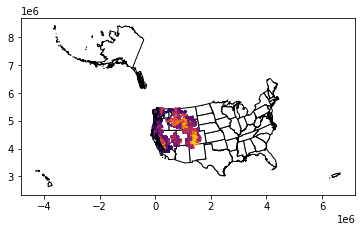

## OK, that looks good, but how do we limit the map extent to the Western US

### Get the total bounding box (or extent) of the *reprojected* GLAS points
* Hint: you did this earlier for the original lat/lon GeoDataFrame, should be easy to repeat for your projected GeoDataFrame.

### Set the x and y axes limits to your projected bounds to update your plot
* See `set_xlim` and `set_ylim`
* You should see your points with state borders overlaid for context

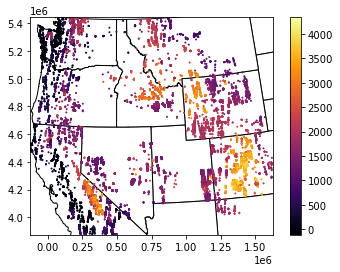

### Extra Credit: create a function to pad the bounds by user-specified distance
* Assume the user knows the units of their projection, and specifies this distance appropriately (e.g., 30000 meters, not 30000 degrees)
* Play with padding distances and replot for a visually pleasing extent (i.e., don't chop off California)

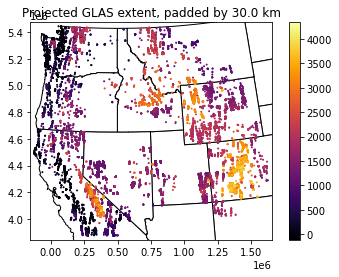

## Summary

OK, we covered a lot of ground with this one. These concepts are fundemental to all aspects of geospatial data analysis, and we'll see them throughout the rest of the quarter. So if some aspects are still a bit fuzzy, know that there will be more opportunities to revisit and discuss.

* We covered basic operations, plotting, Geopandas GeoDataFrames and associated methods/attributes - these are great for most geospaital vector data and analysis.
    * Caveat: the standard GeoPandas tools are not ideally suited for workflows involving billions of points - these cases will require optimization (e.g., https://github.com/geopandas/dask-geopandas) and potentially a different suite of tools.
* Hopefully you got a sense of the most common approaches to define projections (EPSG codes, proj strings, WKT), and now understand some of the tradeoffs between different projections for different objectives involving visualization or quantitative analysis.
    * For most applications, best to avoid using a geographic projection (lat/lon) for analysis (or visualization) due to scaling issues
    * In general, for local studies or smaller areas (<500x500 km), you can use the appropriate UTM zone, which has acceptable distortion in terms of distance, angles and areas
    * For larger areas, probably want to define a custom projection (remember https://projectionwizard.org/) or use a standard regional projection designed for your intended purpose
    * Be careful with Web Mercator - in the coming weeks we'll be using public raster tile datasets prepared with this projection, so try to remember some of the issues highlighted here
* When plotting and doing anlaysis, all of your input datasets must share the same coordinate system, which may require reprojecting one (or more) datasets to match. You can then plot them on the same axes. We will do more of this in coming weeks to combine raster and vector data.